# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

In [155]:
# The dataset collected is related to 17 campaigns that occurred between 
# May 2008 and November 2010, corresponding to a total of 79354 contacts.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [158]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score

warnings.filterwarnings("ignore")

In [160]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [162]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [164]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [166]:
# why are there 43 campaigns found, but the instructions only state 17?
count_c = df["campaign"].value_counts()
count_c

campaign
1     17642
2     10570
3      5341
4      2651
5      1599
6       979
7       629
8       400
9       283
10      225
11      177
12      125
13       92
14       69
17       58
16       51
15       51
18       33
20       30
19       26
21       24
22       17
23       16
24       15
27       11
29       10
28        8
26        8
25        8
31        7
30        7
35        5
32        4
33        4
34        3
42        2
40        2
43        2
56        1
39        1
41        1
37        1
Name: count, dtype: int64

In [168]:
# summary of target y/n responses
count_y = df["y"].value_counts()
count_y

y
no     36548
yes     4640
Name: count, dtype: int64

In [170]:
# target response yes 13%
count_y_percent = df["y"].value_counts(normalize=True) * 100
count_y_percent = count_y_percent.round(0)

print("\nPercentages (rounded):\n", count_y_percent)


Percentages (rounded):
 y
no     89.0
yes    11.0
Name: proportion, dtype: float64


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [173]:
# check and confirm no null values
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [175]:
# The dataset comprises 21 features and more than 40,000 records, including 10 numerical features and 10 categorical features. 

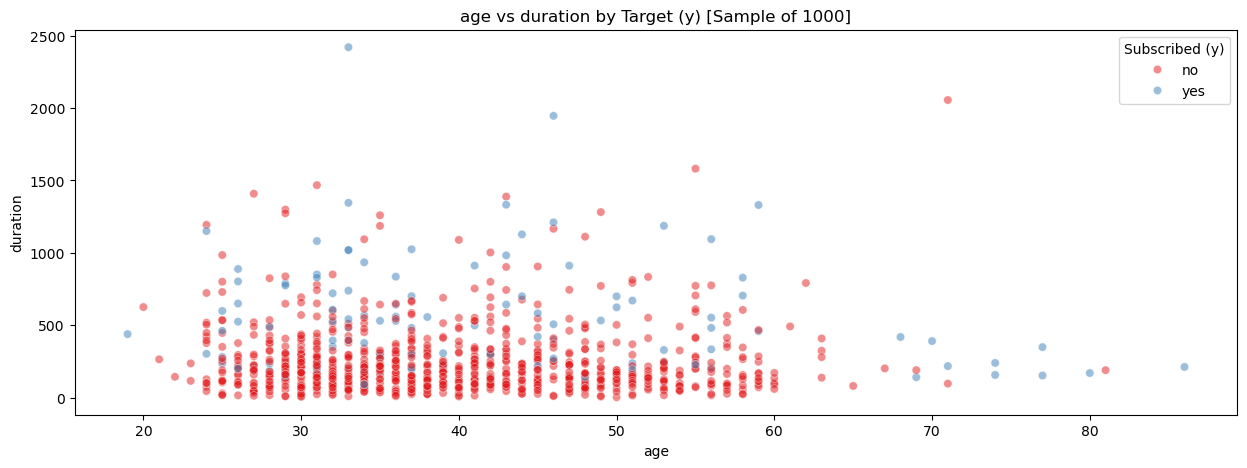

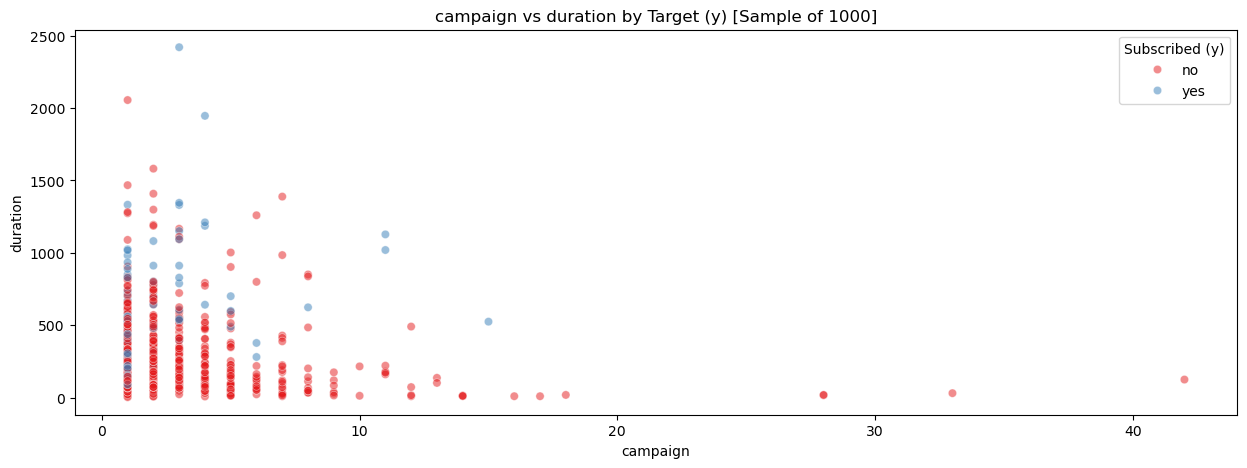

In [177]:
# sample 1000 scatter plot
df_sample = df.sample(1000, random_state=42)

scat = [
    ("age", "duration"),
    ("campaign", "duration")
]

# Loop through pairs
for x, y_feature in scat:
    plt.figure(figsize=(15, 5))
    sns.scatterplot(data=df_sample, x=x, y=y_feature, hue="y", alpha=0.5, palette="Set1")
    plt.title(f"{x} vs {y_feature} by Target (y) [Sample of 1000]")
    plt.legend(title="Subscribed (y)")
    plt.show()

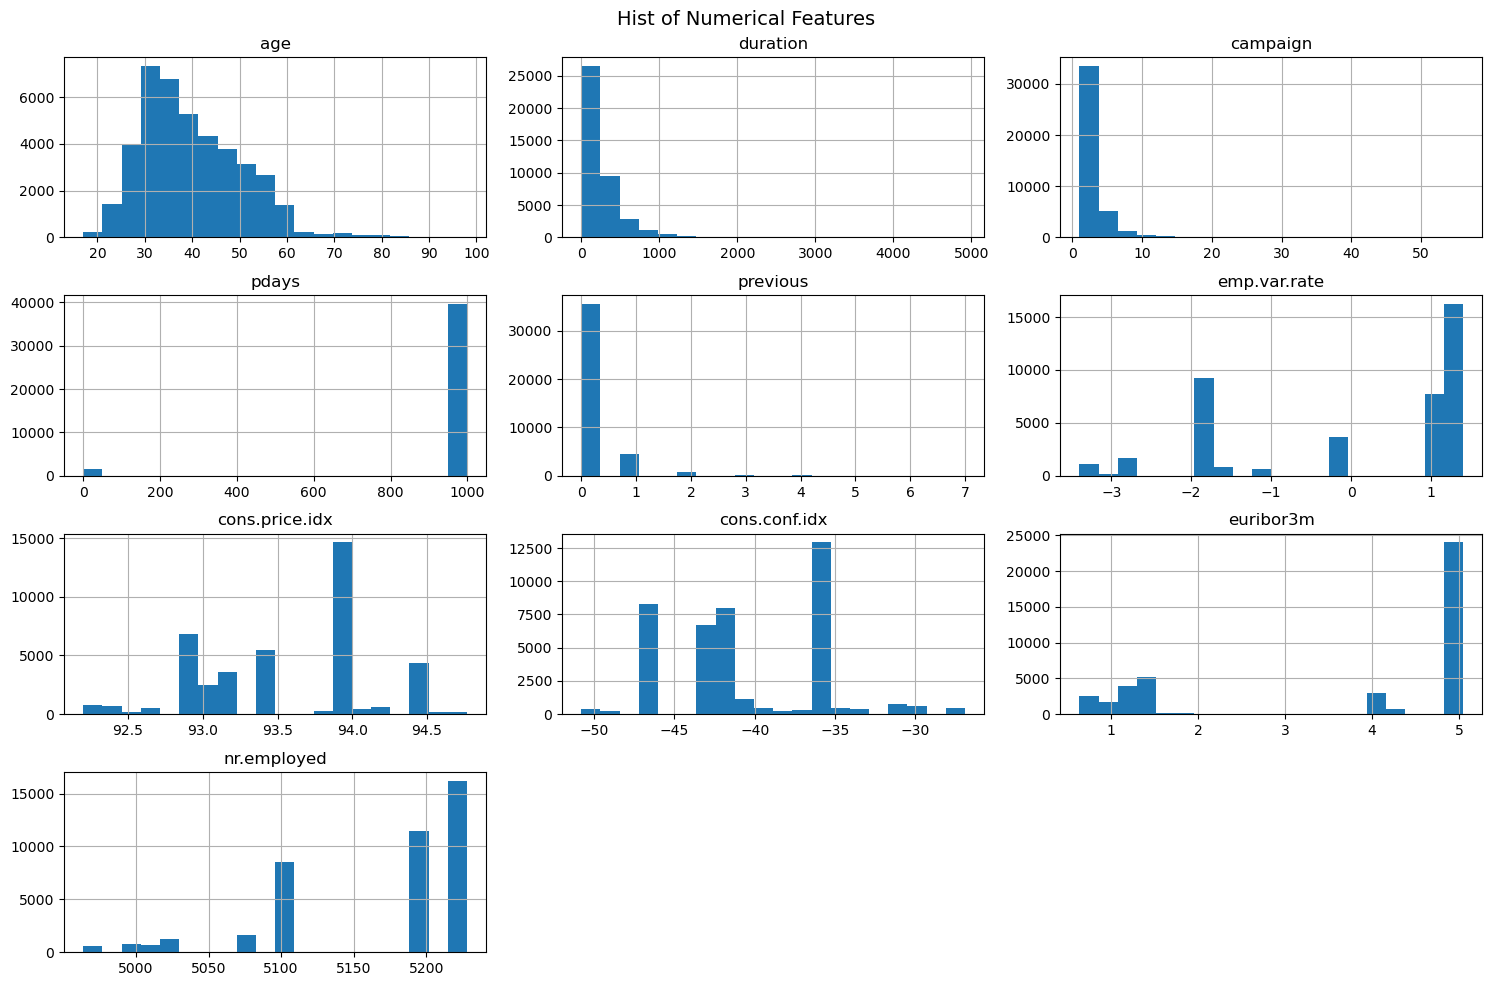

In [178]:
# plot numerical features
df.hist(bins=20, figsize=(15, 10), layout=(4, 3))
plt.suptitle("Hist of Numerical Features", fontsize=14)
plt.tight_layout(pad=1.0)

In [180]:
# drop age > 60
df = df[df["age"] < 60]
count = df["age"].value_counts()

In [181]:
# check for unknown values and drop

In [182]:
count = df["job"].value_counts()
count

job
admin.           10316
blue-collar       9211
technician        6694
services          3961
management        2866
entrepreneur      1439
self-employed     1400
unemployed        1004
housemaid          993
retired            935
student            875
unknown            301
Name: count, dtype: int64

In [183]:
df = df[df["job"] != "unknown"]

In [184]:
count = df["marital"].value_counts()
count

marital
married     23788
single      11458
divorced     4379
unknown        69
Name: count, dtype: int64

In [191]:
df = df[df["marital"] != "unknown"]

In [193]:
count = df["education"].value_counts()
count

education
university.degree      11849
high.school             9306
basic.9y                5952
professional.course     5079
basic.4y                3704
basic.6y                2232
unknown                 1487
illiterate                16
Name: count, dtype: int64

In [195]:
df = df[df["education"] != "unknown"]

In [197]:
count = df["default"].value_counts()
count

default
no         30319
unknown     7816
yes            3
Name: count, dtype: int64

In [199]:
df = df[df["default"] != "unknown"]

In [201]:
count = df["housing"].value_counts()
count

housing
yes        16036
no         13570
unknown      716
Name: count, dtype: int64

In [203]:
df = df[df["housing"] != "unknown"]

In [205]:
count = df["loan"].value_counts()
count

loan
no     24965
yes     4641
Name: count, dtype: int64

In [207]:
df = df[df["loan"] != "unknown"]

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [210]:
# The banking organization has requested an evaluation of the effectiveness of its marketing 
# campaigns in order to determine whether customers are likely to respond positively.

In [212]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29606 entries, 0 to 41186
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             29606 non-null  int64  
 1   job             29606 non-null  object 
 2   marital         29606 non-null  object 
 3   education       29606 non-null  object 
 4   default         29606 non-null  object 
 5   housing         29606 non-null  object 
 6   loan            29606 non-null  object 
 7   contact         29606 non-null  object 
 8   month           29606 non-null  object 
 9   day_of_week     29606 non-null  object 
 10  duration        29606 non-null  int64  
 11  campaign        29606 non-null  int64  
 12  pdays           29606 non-null  int64  
 13  previous        29606 non-null  int64  
 14  poutcome        29606 non-null  object 
 15  emp.var.rate    29606 non-null  float64
 16  cons.price.idx  29606 non-null  float64
 17  cons.conf.idx   29606 non-null  floa

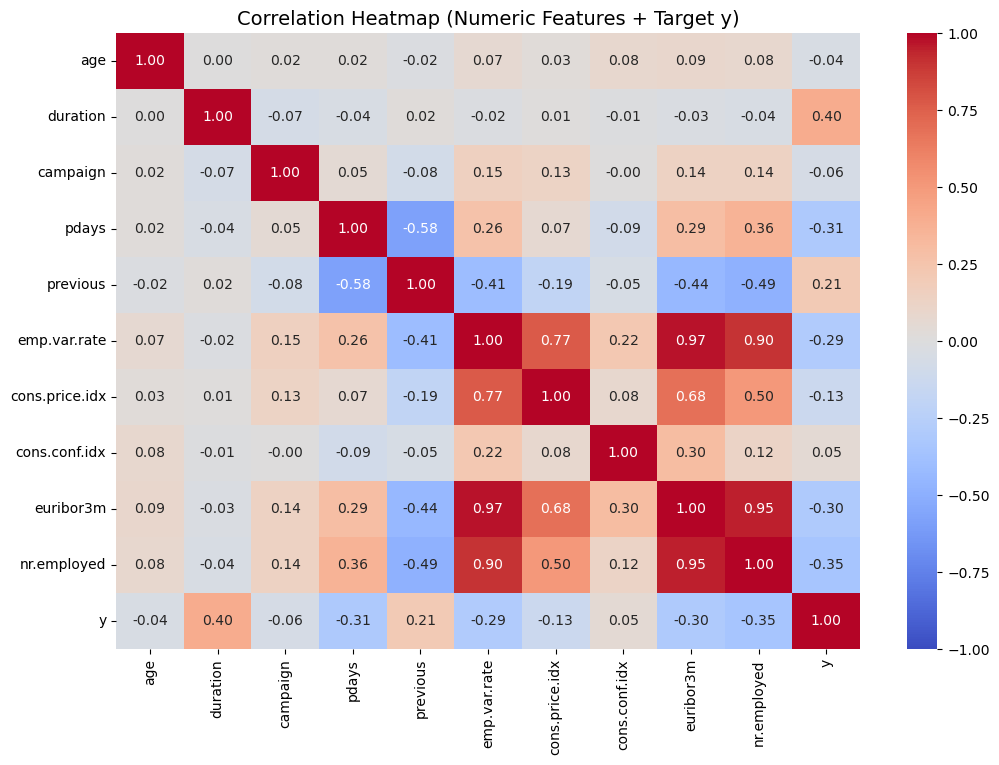

In [214]:
# heatmap of raw data with numerical features before encoding
df_corr = df.copy()
df_corr["y"] = df_corr["y"].map({"no": 0, "yes": 1})
numeric_df = df_corr.select_dtypes(include=["int64", "float64"])
corr = numeric_df.corr().round(2)
plt.figure(figsize=(12, 8))
sns.heatmap(corr, 
            annot=True, 
            fmt=".2f", 
            cmap="coolwarm", 
            vmin=-1, vmax=1, 
            cbar=True)

plt.title("Correlation Heatmap (Numeric Features + Target y)", fontsize=14)
plt.show()

In [215]:
# drop features that have a weak correlation score or correlation score is close to another feature
df = df.drop(columns=["age"])
df = df.drop(columns=["cons.conf.idx"])
df = df.drop(columns=["emp.var.rate"])
df = df.drop(columns=["nr.employed"])

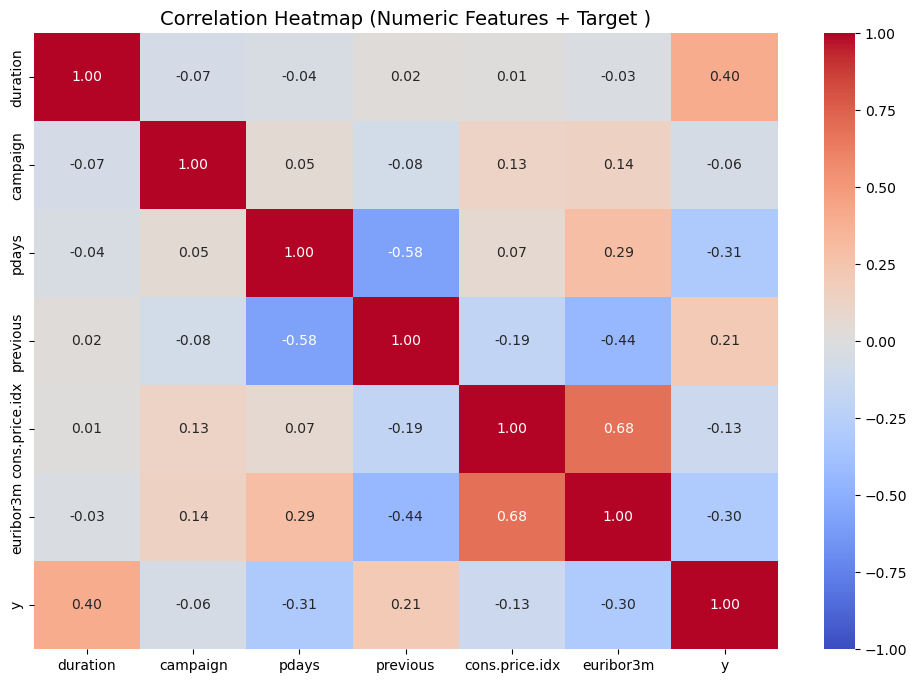

In [218]:
# heatmap after drops
df_corr = df.copy()
df_corr["y"] = df_corr["y"].map({"no": 0, "yes": 1})
numeric_df = df_corr.select_dtypes(include=["int64", "float64"])
corr = numeric_df.corr().round(2)
plt.figure(figsize=(12, 8))
sns.heatmap(corr, 
            annot=True, 
            fmt=".2f", 
            cmap="coolwarm", 
            vmin=-1, vmax=1, 
            cbar=True)

plt.title("Correlation Heatmap (Numeric Features + Target )", fontsize=14)
plt.show()

In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29606 entries, 0 to 41186
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   job             29606 non-null  object 
 1   marital         29606 non-null  object 
 2   education       29606 non-null  object 
 3   default         29606 non-null  object 
 4   housing         29606 non-null  object 
 5   loan            29606 non-null  object 
 6   contact         29606 non-null  object 
 7   month           29606 non-null  object 
 8   day_of_week     29606 non-null  object 
 9   duration        29606 non-null  int64  
 10  campaign        29606 non-null  int64  
 11  pdays           29606 non-null  int64  
 12  previous        29606 non-null  int64  
 13  poutcome        29606 non-null  object 
 14  cons.price.idx  29606 non-null  float64
 15  euribor3m       29606 non-null  float64
 16  y               29606 non-null  object 
dtypes: float64(2), int64(4), object(11)


In [222]:
# seperate features and target 
X = df.drop("y", axis=1)
y = df["y"]

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [225]:
# one-hot encode features
X = pd.get_dummies(X, drop_first=False)
X = X.astype("int32")
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29606 entries, 0 to 41186
Data columns (total 53 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   duration                       29606 non-null  int32
 1   campaign                       29606 non-null  int32
 2   pdays                          29606 non-null  int32
 3   previous                       29606 non-null  int32
 4   cons.price.idx                 29606 non-null  int32
 5   euribor3m                      29606 non-null  int32
 6   job_admin.                     29606 non-null  int32
 7   job_blue-collar                29606 non-null  int32
 8   job_entrepreneur               29606 non-null  int32
 9   job_housemaid                  29606 non-null  int32
 10  job_management                 29606 non-null  int32
 11  job_retired                    29606 non-null  int32
 12  job_self-employed              29606 non-null  int32
 13  job_services         

In [227]:
# label encode target
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y).astype("int32")
print(pd.Series(y).value_counts())

0    26120
1     3486
Name: count, dtype: int64


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [230]:
# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=6625, stratify=y)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [233]:
# calculate baseline, no predict -> 88.%, yes predict -> 11.2%
y_count = pd.Series(y).value_counts(normalize=True) * 100
print(y_count.round(2))

baseline_accuracy = y_count.max()
print(f"Baseline accuracy: {baseline_accuracy:.2f}%")

0    88.23
1    11.77
Name: proportion, dtype: float64
Baseline accuracy: 88.23%


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [236]:
lr = LogisticRegression(random_state=6625)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

### Problem 9: Score the Model

What is the accuracy of your model?

In [239]:
# calculate logistic regression model
print("Logistic Regression Results")
print(classification_report(y_test, y_pred, digits=2))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Logistic Regression Results
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      5225
           1       0.66      0.41      0.51       697

    accuracy                           0.91      5922
   macro avg       0.79      0.69      0.73      5922
weighted avg       0.89      0.91      0.90      5922

Confusion Matrix:
[[5076  149]
 [ 408  289]]


In [241]:
# finding --> the data appears to be imbalanced, .66 for yes/1 and .51 f1 score for true

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [244]:
# build logistic regression, KNN, decision tree, and SVM models
models = {
    "Logistic Regression": LogisticRegression(random_state=6625),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=6625),
    "SVM": SVC()
}

In [246]:
results = []
for name, model in models.items():
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    
    train_time = end - start
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    
    results.append([name, train_time, train_acc, test_acc])

In [247]:
results_df = pd.DataFrame(results, columns=["Model", "Train Time", "Train Accuracy", "Test Accuracy"])
results_df["Train Time"] = results_df["Train Time"].round(2)
results_df["Train Accuracy"] = results_df["Train Accuracy"].round(3)
results_df["Test Accuracy"] = results_df["Test Accuracy"].round(3)
print(results_df)

                 Model  Train Time  Train Accuracy  Test Accuracy
0  Logistic Regression        0.20           0.906          0.906
1                  KNN        0.00           0.924          0.899
2        Decision Tree        0.12           1.000          0.881
3                  SVM       10.53           0.899          0.900


In [248]:
# finding --> All four basic models have 90% accuracy. 

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [250]:
# gender is not part of this dataset, why do they reference it??? 

In [251]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=6625)
scoring = "f1_weighted"


In [252]:
# Attempt to tune logistic Regression 
results = []
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(random_state=6625, max_iter=2000))
])

param_lr = {
    "clf__C": [0.001, .01, 0.1, 1]
}

grid_lr = GridSearchCV(pipe_lr, param_lr, cv=cv, scoring=scoring, n_jobs=-1, refit=True)
grid_lr.fit(X_train, y_train)
y_pred = grid_lr.predict(X_test)

results.append({
    "Model": "Logistic Regression",
    "Best Params": grid_lr.best_params_,
    "Test Acc": round(accuracy_score(y_test, y_pred), 4)
})

results


[{'Model': 'Logistic Regression',
  'Best Params': {'clf__C': 0.1},
  'Test Acc': 0.9076}]

In [253]:
# finding --> best clf_C was 0.1. However, no change in accuracy: run 2 90.1%, run 1 91%

In [254]:
# Attempt to tune KNN
results = []
pipe_knn = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier())
])

param_knn = {
    "clf__n_neighbors": list(range(1, 15))
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=6625)
scoring = "f1_weighted"

grid_knn = GridSearchCV(
    estimator=pipe_knn,
    param_grid=param_knn,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    refit=True,
    verbose=0
)

grid_knn.fit(X_train, y_train)
y_pred = grid_knn.predict(X_test)

results.append({
    "Model": "KNN",
    "Best Params": grid_knn.best_params_,
    "Test Acc": round(accuracy_score(y_test, y_pred), 4)
})

results

[{'Model': 'KNN', 'Best Params': {'clf__n_neighbors': 11}, 'Test Acc': 0.8907}]

In [255]:
# finding --> best num of neighbor was 11. However, no change in accuracy: run 2 89%, run 1 90%

In [256]:
# Attempt to tune decision tree 
# concern --> the test accuracy was 100% and train was 88%

depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50]
results_dt = []

for d in depths:
    model = DecisionTreeClassifier(max_depth=d, random_state=6625, class_weight="balanced")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    results_dt.append({
        "Max Depth": d,
        "Train Acc": round(accuracy_score(y_train, model.predict(X_train)), 4),
        "Test Acc": round(accuracy_score(y_test, y_pred), 4),
        "Test F1w": round(f1_score(y_test, y_pred, average="weighted"), 4)
    })

results = pd.DataFrame(results_dt)
results

,Max Depth,Train Acc,Test Acc,Test F1w
0,1,0.6509,0.6472,0.7098
1,2,0.6509,0.6472,0.7098
2,3,0.7633,0.7673,0.8071
3,4,0.8229,0.8232,0.8500
4,5,0.8301,0.8305,0.8558
5,6,0.8306,0.8278,0.8537
6,7,0.8458,0.8387,0.8619
7,8,0.8665,0.8549,0.8743
8,9,0.8563,0.8374,0.8606
9,10,0.8739,0.8495,0.8692


In [257]:
# finding --> accuracy did not improve after depth of 10. However, no change in accuracy (test): run 2 88%, run 1 88%

In [258]:
# list strong features
df_corr = X.copy()
df_corr["y"] = y

numeric_df = df_corr.select_dtypes(include=["number"])
corr = numeric_df.corr().round(3)
corr_with_y = corr["y"].drop("y")
strong_corr = corr_with_y[(corr_with_y >= 0.20) | (corr_with_y <= -0.20)]

print("Strong correlations with target y:")
print(strong_corr)

Strong correlations with target y:
duration            0.403
pdays              -0.312
previous            0.211
euribor3m          -0.318
poutcome_success    0.305
Name: y, dtype: float64


##### Questions

In [260]:
# I still don't quite understand why after the tunning of the models, there was no or reduced performance in the model(s).
# The overall accuracy remained the same. 